In [80]:
#importing libraries 
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset
from torch.autograd import Variable

import warnings
import cirq
from math import pi
import qsimcirq
warnings.filterwarnings('ignore')

In [81]:
config_path = 'config/preprocessing_config.yaml'
conf = yaml.safe_load(open(config_path,'r'))
train_image_path = conf['train_dataset']['image_path']
test_image_path = conf['test_dataset']['image_path']
train_labels_path = conf['train_dataset']['label_path']
test_labels_path = conf['test_dataset']['label_path']
train_batch_size = conf['train_dataset']['batch_size']
test_batch_size = conf['test_dataset']['batch_size']
columns = conf['train_dataset']['columns']
image_size = conf['image_preprocessing']['image_size']
itype = conf['image_preprocessing']['itype']

In [82]:
from utils.preprocessing import *

In [83]:
#GPU CHECK
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [84]:
# import data
train = pd.read_csv(train_labels_path)
test = pd.read_csv(test_labels_path)

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train[columns[1]].value_counts())
print('-' * 15)
print(test[columns[1]].value_counts())

(413, 12) (103, 3)
---------------
Retinopathy grade
2    136
0    134
3     74
4     49
1     20
Name: count, dtype: int64
---------------
Retinopathy grade
0    34
2    32
3    19
4    13
1     5
Name: count, dtype: int64


In [85]:
# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

In [86]:
train_dataset = EyeData(data = train.iloc[:400, 0:2], 
                      directory  = train_image_path,
                      transform  = train_trans,
                      itype = itype)

train_loader = torch.utils.data.DataLoader(dataset     = train_dataset, 
                                            batch_size  = train_batch_size, 
                                            shuffle     = conf['train_dataset']['shuffle'], 
                                            num_workers = 4)


torch.Size([16, 3, 224, 224])


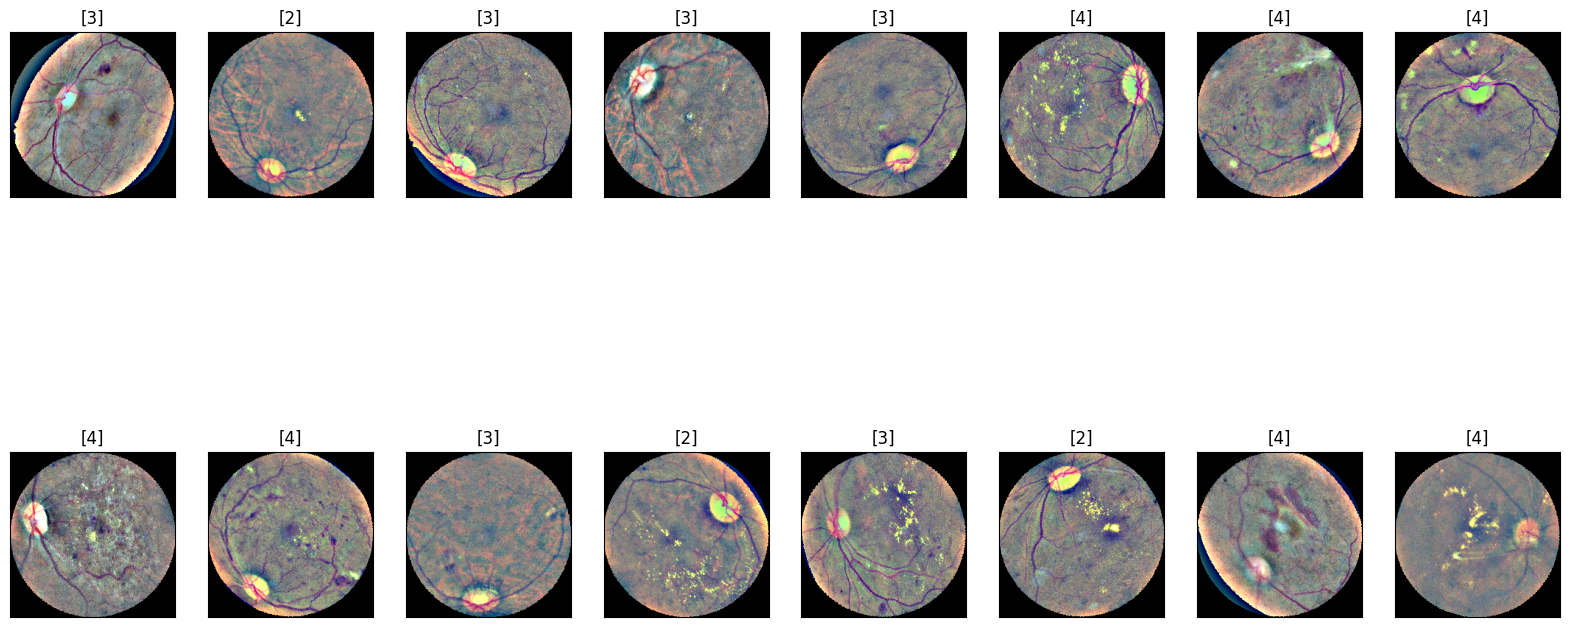

In [87]:
#EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeData(data = train.iloc[0:32, 0:3], 
                      directory  = train_image_path,
                      transform  = train_trans,
                      itype = itype)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = train_batch_size, 
                                            shuffle     = conf['train_dataset']['shuffle'], 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):
    # extract data
    inputs = data['image']
    print(inputs.shape)
    labels = data['label'].view(-1, 1)
    # labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break


In [88]:
test_dataset = EyeData(data = test.iloc[:96, 0:2], 
                      directory  = test_image_path,
                      transform  = test_trans,
                      itype = itype,
                      do_random_crop = conf['test_dataset']['do_random_crop'])

test_loader = torch.utils.data.DataLoader(dataset     = test_dataset, 
                                            batch_size  = test_batch_size, 
                                            shuffle     = conf['test_dataset']['shuffle'], 
                                            num_workers = 4)

torch.Size([16, 3, 224, 224])


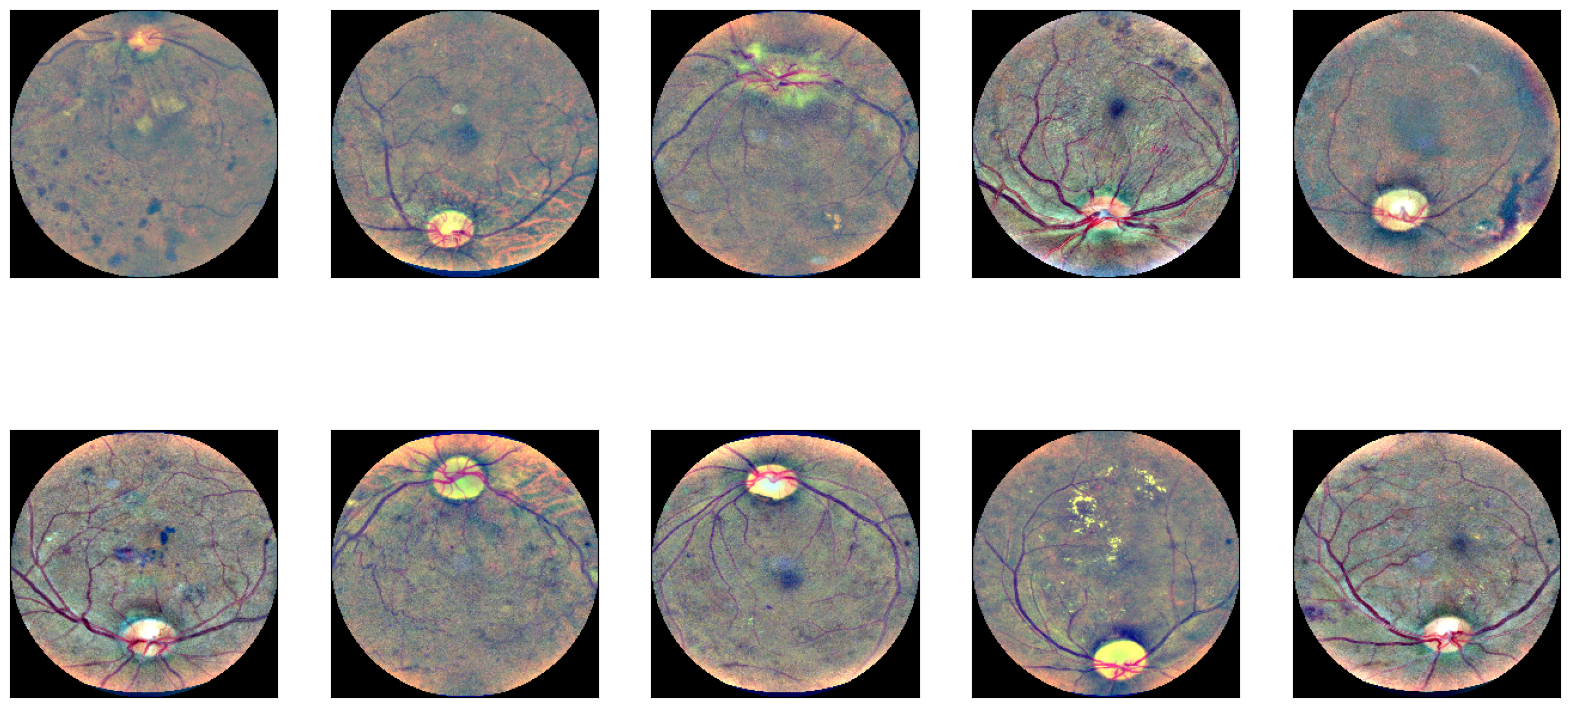

In [48]:
#EXAMINE FIRST BATCH (TEST)

# get dataset
sample = EyeData(data = test.iloc[0:32, 0:2], 
                      directory  = test_image_path,
                      transform  = test_trans,
                      itype = itype,
                      do_random_crop = conf['test_dataset']['do_random_crop'])

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = test_batch_size, 
                                            shuffle     = conf['test_dataset']['shuffle'], 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    print(inputs.shape)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(10):
        ax = fig.add_subplot(2, int(10/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))

    break
    

In [49]:
# baseModel = torchvision.models.efficientnet_b7(pretrained=True)

In [89]:
# named_layers = dict(baseModel.named_modules())
# print(named_layers)

In [90]:
# new_model = nn.Sequential(*list(baseModel.children())[:-1])

In [91]:
# x = torch.rand(1, 3, 224, 224)
# train_nodes, eval_nodes = torchvision.models.feature_extraction.get_graph_node_names(new_model)
# print(train_nodes)
# print(eval_nodes)
# # return_nodes = conf['model']['return_nodes']
# # model = create_feature_extractor(baseModel, return_nodes)
# y = new_model(x)
# print(y[return_nodes].shape)

In [92]:
# train_tensor = []
# for batch_i, data in enumerate(train_loader):
#     # extract data
#     inputs = data['image']
#     y_pred = model(inputs)
#     print(y_pred[return_nodes[0]].shape)
#     train_tensor.append(y_pred[return_nodes[0]])
#     labels = data['label'].view(-1, 1)

In [93]:
# torch.save(train_tensor, 'dataset_tensor/train_tensor.bin')
# x_loaded = torch.load('dataset_tensor/train_tensor.bin')
# print(len(x_loaded), x_loaded[0].shape)

In [94]:
# for batch, data in enumerate(train_loader):
#     print(batch)

In [52]:
def loading_bar(current_value, total_value, bar_length=40):
    progress = min(1.0, current_value / total_value)
    arrow = '■' * int(progress * bar_length)
    spaces = ' ' * (bar_length - len(arrow))
    print(f'\r[{arrow}{spaces}] {int(progress * 100)}%', end='', flush=True)

In [66]:
class ClassicalModel(nn.Module):
    def __init__(self):
        super(ClassicalModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 2, stride = 1 )
        self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 48, kernel_size = 2, stride = 1 )
        self.conv = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 2, stride = 1)
        self.fc1 = nn.Linear(48*6*6, 50)
        self.fc2 = nn.Linear(50, 5)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        self.minpool = nn.AvgPool2d(2, stride = 2)
        self.activation = nn.SiLU()
        
    def forward(self, x):
        # print(x.size())
        x = self.activation(self.maxpool(self.conv1(x))) # 12x111x111
        # print(x.size())
        x = torch.relu(self.maxpool(self.conv2(x))) # 48x55x55
        # print(x.size())
        x = self.activation(self.maxpool(self.conv(x))) # 48x27x27
        # print(x.size())
        x = torch.relu(self.maxpool(self.conv(x))) # 48x13x13
        # print(x.size())
        x = self.activation(self.maxpool(self.conv(x))) # 48x6x6
        # print(x.size())
        x = x.view(-1, 48*6*6)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

In [67]:
model = ClassicalModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [68]:
r_loss = 0.0
start_time = time.time()
count = 0
for epoch in range(1):
    print("Running epoch: " , epoch)
    for i, data in enumerate(train_loader):
        inputs, labels = data['image'], data['label']
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(inputs.size(), outputs.size(), labels.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        r_loss += loss.item()
        loading_bar(i, 24)
delta = time.time() - start_time
print(f'\nFinished Training in {delta: 0.6f} sec')
print("Running loss: ", r_loss)

Running epoch:  0
[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100%
Finished Training in  34.327568 sec
Running loss:  39.81127643585205


In [69]:
total = 0
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data['image'], data['label']
        output = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"total: {total}, correct = {correct}")
print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

total: 16, correct = 6
total: 32, correct = 12
total: 48, correct = 14
total: 64, correct = 17
total: 80, correct = 22
total: 96, correct = 30
Accuracy of the network on the 96 test images: 31.25%


In [26]:
save_path = "model/model_classic_v2.pth"
torch.save(model.state_dict(), save_path)